# Perform a two-sided KS-test using the DMSO or no treatment heart #7 (healthy) cells to assess how different each feature is based on the two populations

## Import libraries

In [1]:
import pathlib
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pycytominer.cyto_utils import infer_cp_features

## Define KS-test function to generate dataframe

In [2]:
def perform_ks_test(
    df1: pd.DataFrame, df2: pd.DataFrame, cp_features: list[str]
) -> pd.DataFrame:
    """Perform and return a data frame with the KS-test results per CellProfiler feature.

    Args:
        df1 (pd.DataFrame): First data frame in the ks-test (will be represented by positive values if greater distribution)
        df2 (pd.DataFrame): First data frame in the ks-test (will be represented by negative values if greater distribution)
        cp_features (list[str]): List of strings with the names of the CellProfiler features to perform the ks-test on

    Returns:
        pd.DataFrame: Data frame containing ks-test results
    """
    ks_results = []
    for feature in cp_features:
        result = stats.ks_2samp(df1[feature], df2[feature])
        ks_statistic = result.statistic
        p_value = result.pvalue
        statistic_location = result.statistic_location
        statistic_sign = result.statistic_sign

        ks_test_result = ks_statistic * statistic_sign

        ks_results.append(
            {
                "Feature": feature,
                "KS Statistic": ks_statistic,
                "P-Value": p_value,
                "Direction": statistic_sign,
                "Stat Location": statistic_location,
                "KS_test_result": ks_test_result,
            }
        )

    ks_results_df = pd.DataFrame(ks_results)
    ks_results_df["-log10pval"] = -np.log10(ks_results_df["P-Value"])
    ks_results_df["Compartment"] = ks_results_df["Feature"].str.split("_").str[0]
    ks_results_df["Measurement"] = ks_results_df["Feature"].str.split("_").str[1]

    return ks_results_df

## Read in plate 4 feature selected parquet file

In [3]:
plate4_df = pd.read_parquet(
    pathlib.Path(
        "../3.process_cfret_features/data/single_cell_profiles/localhost231120090001_sc_feature_selected.parquet"
    )
)

# Fill NaN values in the "Metadata_treatment" column with "None"
plate4_df['Metadata_treatment'].fillna("None", inplace=True)

# Get columns that are cp_features (will be the same for shuffled)
cp_features = infer_cp_features(plate4_df)

print(plate4_df.shape)
plate4_df.head()

(16887, 657)


,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,...,Nuclei_Texture_InverseDifferenceMoment_ER_3_01_256,Nuclei_Texture_InverseDifferenceMoment_ER_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumVariance_ER_3_03_256,Nuclei_Texture_SumVariance_Hoechst_3_03_256,Nuclei_Texture_SumVariance_Mitochondria_3_03_256,Nuclei_Texture_SumVariance_PM_3_01_256
0,B,2,2,Healthy,None,None,199.395062,268.792593,193.914743,269.641581,...,0.687565,0.692428,0.536752,0.878746,0.686496,0.963962,-0.324604,-0.291686,-0.238556,-0.351116
1,B,2,2,Healthy,None,None,303.540675,350.732143,314.842955,368.939934,...,0.486515,0.605508,0.741645,0.972737,1.456869,1.470718,-0.301586,-0.305400,-0.246969,-0.376565
2,B,2,2,Healthy,None,None,700.388506,371.800000,708.112277,380.711178,...,1.183681,1.314340,1.121741,1.188526,1.434736,1.417333,-0.343746,-0.358660,-0.252320,-0.383783
3,B,2,2,Healthy,None,None,855.869318,481.075758,877.161009,515.307396,...,0.673890,0.084512,1.072561,0.900595,0.934998,0.540008,-0.271485,-0.305855,-0.240756,-0.278494
4,B,2,2,Healthy,None,None,586.624514,509.892023,590.453967,504.113587,...,0.551062,0.608475,1.091661,1.060037,1.181420,0.982785,-0.330949,-0.263325,-0.253783,-0.356839


## Shuffle the plate 4 data to get a randomized data frame to compare to the non-shuffled results

In [4]:
# Separate features from metadata
metadata_columns = [col for col in plate4_df.columns if col.startswith('Metadata')]
feature_columns = [col for col in plate4_df.columns if col not in metadata_columns]

# Generate dataframes with respective columns
metadata_df = plate4_df[metadata_columns]
feature_df = plate4_df[feature_columns]

# Set a random state
random_state = 0

# Convert feature_df to numpy array and shuffle
feature_array = feature_df.values
for column in feature_array.T:
    np.random.seed(random_state)
    np.random.shuffle(column)

# Combine shuffled features with metadata
shuffled_feature_df = pd.DataFrame(feature_array, columns=feature_columns)
shuffled_plate4_df = pd.concat([metadata_df, shuffled_feature_df], axis=1)

print(shuffled_plate4_df.shape)
shuffled_plate4_df.head()

(16887, 657)


,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,...,Nuclei_Texture_InverseDifferenceMoment_ER_3_01_256,Nuclei_Texture_InverseDifferenceMoment_ER_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumVariance_ER_3_03_256,Nuclei_Texture_SumVariance_Hoechst_3_03_256,Nuclei_Texture_SumVariance_Mitochondria_3_03_256,Nuclei_Texture_SumVariance_PM_3_01_256
0,B,2,2,Healthy,None,None,199.395062,268.792593,193.914743,269.641581,...,0.615485,0.388515,0.620319,0.123986,0.389611,0.355329,-0.308973,-0.289678,-0.124283,-0.194678
1,B,2,2,Healthy,None,None,303.540675,350.732143,314.842955,368.939934,...,0.539719,0.350734,-0.242386,0.372252,0.768976,0.496552,-0.303291,-0.251719,-0.156259,-0.331548
2,B,2,2,Healthy,None,None,700.388506,371.800000,708.112277,380.711178,...,-0.181014,0.421551,0.038230,0.273010,0.443678,0.163915,-0.275738,-0.251501,-0.224128,-0.314719
3,B,2,2,Healthy,None,None,855.869318,481.075758,877.161009,515.307396,...,0.741161,0.309432,0.332055,0.505526,0.784912,0.774640,-0.274893,-0.310401,-0.230156,-0.341124
4,B,2,2,Healthy,None,None,586.624514,509.892023,590.453967,504.113587,...,1.146822,1.249438,1.759052,1.676115,1.531598,1.447616,-0.342429,-0.268048,-0.259360,-0.384495


## Split shuffled and non-shuffled data based on treatment for heart #7 only

In [5]:
# Subset the data for heart #7 with DMSO treatment
heart_7_DMSO = plate4_df[(plate4_df['Metadata_treatment'] == 'DMSO') & (plate4_df['Metadata_heart_number'] == 7)]

# Subset the data for heart #7 with no treatment
heart_7_None = plate4_df[(plate4_df['Metadata_treatment'] == 'None') & (plate4_df['Metadata_heart_number'] == 7)]

# Subset the data for heart #7 with DMSO treatment (shuffled)
shuffled_heart_7_DMSO = shuffled_plate4_df[(shuffled_plate4_df['Metadata_treatment'] == 'DMSO') & (shuffled_plate4_df['Metadata_heart_number'] == 7)]

# Subset the data for heart #7 with no treatment (shuffled)
shuffled_heart_7_None = shuffled_plate4_df[(shuffled_plate4_df['Metadata_treatment'] == 'None') & (shuffled_plate4_df['Metadata_heart_number'] == 7)]

print("Number of cells for heart #7 DMSO treatment:", heart_7_DMSO.shape[0])
print("Number of cells for heart #7 no treatment:", heart_7_None.shape[0])

Number of cells for heart #7 DMSO treatment: 944
Number of cells for heart #7 no treatment: 2821


## Perform KS-test for non-shuffled data

In [6]:
ks_results_df = perform_ks_test(heart_7_DMSO, heart_7_None, cp_features)

print(ks_results_df.shape)
ks_results_df.head()

(638, 9)


,Feature,KS Statistic,P-Value,Direction,Stat Location,KS_test_result,-log10pval,Compartment,Measurement
0,Cytoplasm_AreaShape_Compactness,0.111339,4.273007e-08,1,0.147759,0.111339,7.369266,Cytoplasm,AreaShape
1,Cytoplasm_AreaShape_Eccentricity,0.040359,1.929903e-01,-1,0.555642,-0.040359,0.714464,Cytoplasm,AreaShape
2,Cytoplasm_AreaShape_Extent,0.037701,2.590626e-01,-1,-0.816679,-0.037701,0.586595,Cytoplasm,AreaShape
3,Cytoplasm_AreaShape_FormFactor,0.111339,4.273007e-08,-1,-0.673653,-0.111339,7.369266,Cytoplasm,AreaShape
4,Cytoplasm_AreaShape_MajorAxisLength,0.076865,4.376120e-04,-1,-0.186740,-0.076865,3.358911,Cytoplasm,AreaShape


## Perform KS-test for shuffled data

In [7]:
shuffled_ks_results_df = perform_ks_test(shuffled_heart_7_DMSO, shuffled_heart_7_None, cp_features)

print(shuffled_ks_results_df.shape)
shuffled_ks_results_df.head()

(638, 9)


,Feature,KS Statistic,P-Value,Direction,Stat Location,KS_test_result,-log10pval,Compartment,Measurement
0,Cytoplasm_AreaShape_Compactness,0.031972,0.453313,-1,0.813296,-0.031972,0.343602,Cytoplasm,AreaShape
1,Cytoplasm_AreaShape_Eccentricity,0.032443,0.434739,1,0.323309,0.032443,0.361772,Cytoplasm,AreaShape
2,Cytoplasm_AreaShape_Extent,0.029391,0.561642,1,0.937825,0.029391,0.250540,Cytoplasm,AreaShape
3,Cytoplasm_AreaShape_FormFactor,0.031972,0.453313,1,-1.065749,0.031972,0.343602,Cytoplasm,AreaShape
4,Cytoplasm_AreaShape_MajorAxisLength,0.035330,0.330840,1,-0.448564,0.035330,0.480382,Cytoplasm,AreaShape


Note: Positive values if the empirical distribution function of **DMSO** exceeds the empirical distribution function of **no treatment** at statistic_location, otherwise negative.

## Generate volcano plot visualizations for each dataset

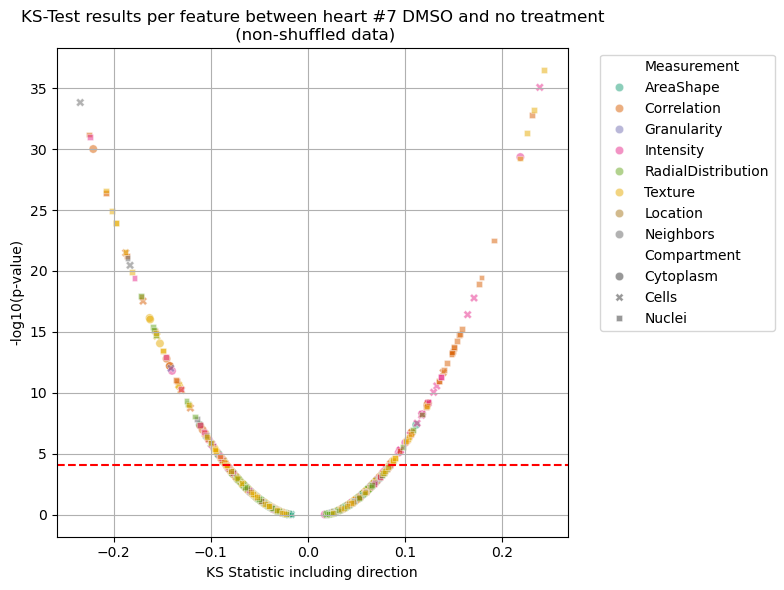

In [8]:
# Plot the volcano plot using Seaborn with legend
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ks_results_df, x='KS_test_result', y='-log10pval', hue='Measurement', style='Compartment', palette='Dark2', alpha=0.5)
plt.title('KS-Test results per feature between heart #7 DMSO and no treatment\n (non-shuffled data)')
plt.xlabel('KS Statistic including direction')
plt.ylabel('-log10(p-value)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Add a horizontal line for p-value threshold of 0. divided by the number of features
plt.axhline(y=-np.log10(0.05 / ks_results_df.shape[0]), color='red', linestyle='--')

plt.tight_layout()
plt.savefig("./figures/ks_test_healthy_dmso_none.png", dpi=500)

plt.show()

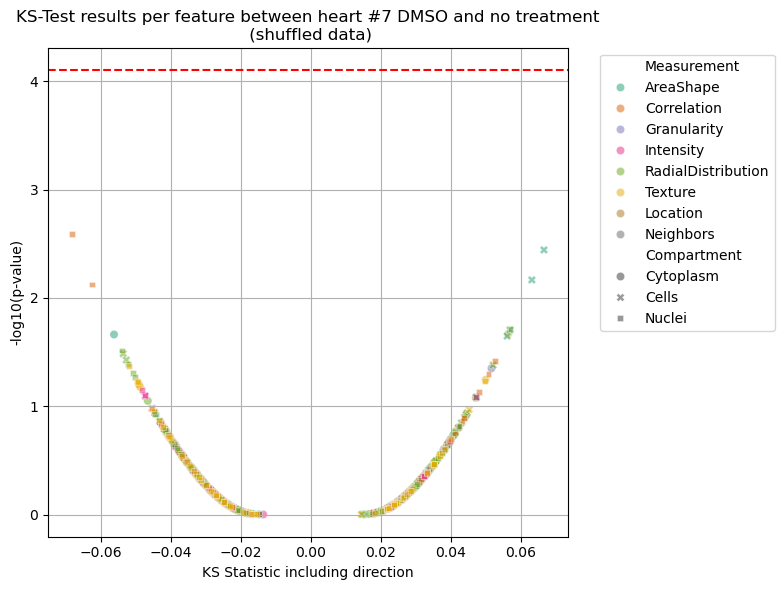

In [9]:
# Plot the volcano plot using Seaborn with legend
plt.figure(figsize=(8, 6))
sns.scatterplot(data=shuffled_ks_results_df, x='KS_test_result', y='-log10pval', hue='Measurement', style='Compartment', palette='Dark2', alpha=0.5)
plt.title('KS-Test results per feature between heart #7 DMSO and no treatment\n (shuffled data)')
plt.xlabel('KS Statistic including direction')
plt.ylabel('-log10(p-value)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Add a horizontal line for p-value threshold of 0. divided by the number of features
plt.axhline(y=-np.log10(0.05 / shuffled_ks_results_df.shape[0]), color='red', linestyle='--')

plt.tight_layout()
plt.savefig("./figures/ks_test_healthy_dmso_none_shuffled.png", dpi=500)

plt.show()

## Go over the non-shuffled data to assess top differential features

In [13]:
# Print the sorted dataframe to see the top features in both directions
sorted_df = ks_results_df.sort_values(by="KS_test_result", ascending=False)

sorted_df

,Feature,KS Statistic,P-Value,Direction,Stat Location,KS_test_result,-log10pval,Compartment,Measurement
574,Nuclei_Texture_AngularSecondMoment_PM_3_01_256,0.243183,3.129211e-37,1,0.064699,0.243183,36.504565,Nuclei,Texture
297,Cells_Intensity_MinIntensityEdge_Actin,0.238468,8.391773e-36,1,-0.155218,0.238468,35.076146,Cells,Intensity
633,Nuclei_Texture_InverseDifferenceMoment_PM_3_03...,0.232261,5.690306e-34,1,0.134650,0.232261,33.244864,Nuclei,Texture
452,Nuclei_Correlation_K_PM_Actin,0.230711,1.609651e-33,1,-0.237081,0.230711,32.793268,Nuclei,Correlation
632,Nuclei_Texture_InverseDifferenceMoment_PM_3_01...,0.225538,4.852546e-32,1,0.381478,0.225538,31.314030,Nuclei,Texture
...,...,...,...,...,...,...,...,...,...
637,Nuclei_Texture_SumVariance_PM_3_01_256,0.208197,2.470898e-27,-1,-0.290883,-0.208197,26.607145,Nuclei,Texture
34,Cytoplasm_Correlation_Correlation_ER_PM,0.220888,9.696896e-31,-1,0.003369,-0.220888,30.013367,Cytoplasm,Correlation
503,Nuclei_Intensity_MADIntensity_PM,0.224372,1.034695e-31,-1,-0.337399,-0.224372,30.985187,Nuclei,Intensity
440,Nuclei_Correlation_K_Actin_PM,0.225142,6.282095e-32,-1,-0.310771,-0.225142,31.201895,Nuclei,Correlation


In [11]:
# Set variable for significance value to use in print statement
significance_value = -np.log10(0.05 / ks_results_df.shape[0])

# Determine the number of features above and below the significance line
above_threshold = ks_results_df[ks_results_df['-log10pval'] > significance_value].shape[0]
below_threshold = ks_results_df[ks_results_df['-log10pval'] <= significance_value].shape[0]

print(f"Number of features above significance line (-log10pval > {significance_value}):", above_threshold)
print(f"Number of features below significance line (-log10pval <= {significance_value}):", below_threshold)

Number of features above significance line (-log10pval > 4.1058506743851435): 173
Number of features below significance line (-log10pval <= 4.1058506743851435): 465


## Extract the top differential feature for each population

In [14]:
# Extract the first and last row Feature names
first_feature = sorted_df.iloc[0]['Feature']
last_feature = sorted_df.iloc[-1]['Feature']

# Create a list containing the two features
selected_features = [first_feature, last_feature]

# Print the list of selected features
print(selected_features)

['Nuclei_Texture_AngularSecondMoment_PM_3_01_256', 'Cells_Neighbors_SecondClosestDistance_Adjacent']


## Density plots of these features comparing between treatment

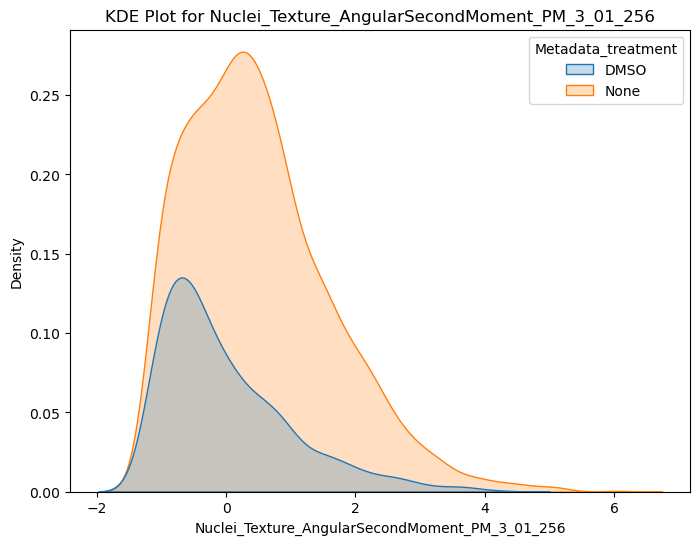

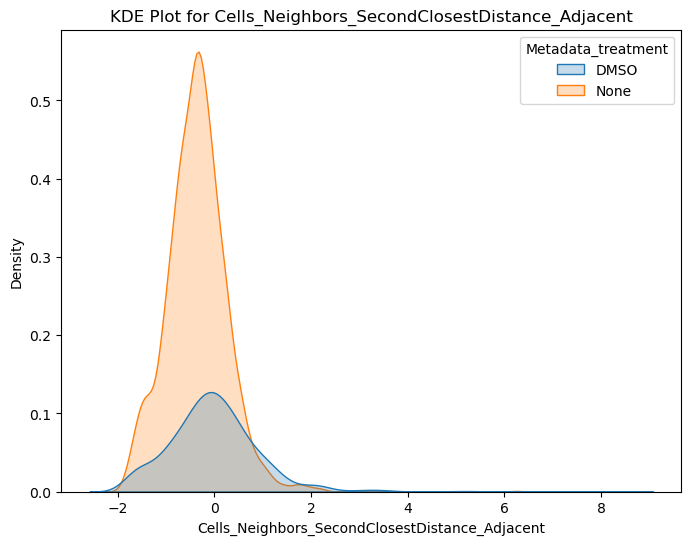

In [16]:
# Filter the plate_4_df DataFrame to include only rows with Metadata_heart_number 7
filtered_plate_df = plate4_df[plate4_df["Metadata_heart_number"] == 7]

# Generate KDE plots for each feature in selected_features with hue based on Metadata_treatment
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=filtered_plate_df, x=feature, hue="Metadata_treatment", fill=True)
    plt.title(f"KDE Plot for {feature}")
    plt.show()

### Look at the cell counts across treatments

In [17]:
# Count the number of cells for each Metadata_treatment
treatment_counts = filtered_plate_df['Metadata_treatment'].value_counts()

# Print the counts
print(treatment_counts)


None    2821
DMSO     944
Name: Metadata_treatment, dtype: int64
